# Intro

[Luminescent AI](https://luminescentai.com/) brings generative AI to photonics and RF. It empowers engineers to create complex optimal components just in a few lines of code! Specifically we created a GPU accelerated and automatic differentiation (AD) compatible FDTD package for simulation and inverse design of photonic integrated circuits (PIC), RF microstrip circuits, antennas and metasurfaces. Experimental release 🥼. Expect bugs 🐛🐞

[Follow us](https://www.linkedin.com/company/luminescent-ai/about) for updates and bug fixes!

# Links
[GitHub](https://github.com/paulxshen/Luminescent.jl): Star us :) We respond to issues within a day  
[LinkedIn](https://www.linkedin.com/company/luminescent-ai/about): Follow us for new features and bug fixes  
[Youtube](https://www.youtube.com/playlist?list=PLaK09N11V08geHeqyLJLDAW0tiDeJtnd4): Video tutorials  
[Company](luminescentai.com): Consulting, collaboration, funding, publication opportunities available  
[White Paper](https://docs.google.com/document/d/1b1kfDdRHw95AsR8zhrZYsHfCHLnULIO7uOYu8PxKQTM/edit?usp=sharing): Generative AI Cells for Semiconductor Photonics Design
Email: pxshen@alumni.stanford.edu info@luminescentai.com  
WhatsApp: 650-776-7724  
WeChat: pxshen1230 懂中文

# Installation
## Windows
1. [download]() & unzeip backend binaries. Add **where_you_unzipped**\LuminescentCompiled\bin to Path (using "edit environmental variables")
2. Install Anaconda distribution of Python . Inside  Anaconda Prompt do `pip install  luminescent`
## Linux
Please request

# Usage and conventions

We do simulation and generative inverse design supporting multi wavelength and multi mode in 3D or 2.5D. Currently, simulation runs on CPU or GPU but generative design is only on CPU. 

We lay out using Python  gdsfactory which is integrated with KLayout. Can also import .gds into gdsfactory . Internally, gdsfactory component and layer stack let generate a 3D mesh which is clipped vertically some depths above and below `core_layer`. By default,
we apply a SOI 220nm node (Si, SiN and Ge layers) implemented by [`gdsfactory.generic_tech`](https://gdsfactory.github.io/gdsfactory/notebooks/03_layer_stack.html#layerstack) layer stack. `luminescent.MATERIALS` maps the material tag of a layer in the layer stack to its property eg `MATERIALS["si"]["epsilon"]`. Can create your own LAYER_STACK and MATERIALS for your process node.

We automatically extend waveguides and adds margins but port locations remain fixed thus not affecting sparams.  Specify port pairs as eg "2,1" which is equivalent to `o2@0,o1@0` meaning optical_port_number@mode_number. 

Each simulation or design optimization run is saved to a folder inside working directory `wd` which can be passed as param in `write_sparams` or `gcell_problem`. Can access saved runs via `show_solution()`, `load_solution()`, `finetune()` which act on latest modified run folder if `name` not specified.  





# Generative AI inverse design
We introduce GCells (generative cells), a natural evolution of PCells (parametric cells) in semiconductor design . Given a set of inverse design objectives, a GCell will generate optimal geometry using adjoint optimization while ensuring manufacturability by enforcing minimum feature lengths.

In examples below, `gcells.mimo` (multi in multi out) is just a gdsfactory component with configurable waveguide ports, simple slab as pre-optimization geometry, and overlying rectangular design regions. Dimensions `l` along x and `w` along y. Ports are numbered incrementally: west (SW->NW) -> east (SE->NE) -> south (SW->SE) -> north (NW->NE). By default, they're spaced equally on a side. Example: `west=1, east=2` places port 1 on west, ports 2 & 3 on east. But can also individually specify their locations and widths. Example : `west=[1.0, 2.5], wwg_west=[0.5, 0.4]`.

`lmin` is minimum length scale . No fill or void features smaller than `lmin`.

`N=True` optimizes in 2.5D which is significantly faster than 3D. Examples done at low resolution and lax convergence for speed. For accuracy, the result must be finetuned in 3D at finer resolution, a feature that can be requested from Luminescent AI .


## Generative cells PDK for passive devices 


### 1x2 splitter MMI (tutorial)
1.55um wavelength 1x2 splitter. Symmetric about y so only need to specify T21=1.0. Data saved to `name` folder inside working directory. We start 30 iteratiions of adjoint optimization.

In [3]:
from pprint import pprint
import luminescent as lumi

name="1x2_splitter"
c = lumi.gcells.mimo(west=1, east=2, l=3.0, w=3.0, wwg=.5, name=name)
targets = {"tparams":{1.55: {"2,1": 0.5}}}

prob = lumi.gcell_problem(
    c, targets, 
    symmetries=[1], lmin=0.15, dx=0.05, 
    N=True, iters=10)
sol = lumi.solve(prob)


          using simulation folder C:\Users\pxshe\OneDrive\Desktop\Luminescent.jl\lumi\1x2_splitter
          started julia process
          compiling julia code...
          
setting up simulation...
using CPU backend.
starting optimization... first iter will be slow due to adjoint compilation.

(1) losses tparams: 0.053727508
weighted total loss 0.053727508
108.264136 seconds (37.95 M allocations: 25.718 GiB, 31.86% gc time, 24.85% compilation time)

(2) losses tparams: 0.053715587
weighted total loss 0.053715587
99.803393 seconds (21.96 M allocations: 24.716 GiB, 46.89% gc time, 0.12% compilation time)

(3) losses tparams: 0.048687756
weighted total loss 0.048687756
100.702631 seconds (21.75 M allocations: 24.702 GiB, 47.47% gc time, 0.00% compilation time)

(4) losses tparams: 0.04484284
weighted total loss 0.04484284
100.261874 seconds (21.75 M allocations: 24.702 GiB, 47.53% gc time, 0.00% compilation time)

(5) losses tparams: 0.021944284
weighted total loss 0.021944284
104.609

C:\Users\pxshe\AppData\Roaming\Python\Python311\site-packages\luminescent\gplugins\luminescent\inverse_design.py:146: UserWarning: Setting `Unnamed_659_0_0.xmin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_659_0_0.dxmin` instead.
  g.xmin = x0
C:\Users\pxshe\AppData\Roaming\Python\Python311\site-packages\luminescent\gplugins\luminescent\inverse_design.py:147: UserWarning: Setting `Unnamed_659_2000_0.ymin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_659_2000_0.dymin` instead.
  g.ymin = y0


Can optionally optimize more using `finetune`

In [5]:
lumi.finetune(iters=5)


          using simulation folder C:\Users\pxshe\OneDrive\Desktop\Luminescent.jl\lumi\1x2_splitter
          started julia process
          compiling julia code...
          
setting up simulation...
loading saved design...
using CPU backend.
starting optimization... first iter will be slow due to adjoint compilation.

(1) losses tparams: 0.01933217
weighted total loss 0.01933217


KeyboardInterrupt: 

{'1.55': {'o1@0,o1@0': 0.010482601, 'o2@0,o1@0': 0.5120458}}
showing solution from C:\Users\pxshe\OneDrive\Desktop\Luminescent.jl\lumi\1x2_splitter
loading solution from C:\Users\pxshe\OneDrive\Desktop\Luminescent.jl\lumi\1x2_splitter
Converting an image file to a GDS file..
width:80
height:40
{'path': 'C:\\Users\\pxshe\\OneDrive\\Desktop\\Luminescent.jl\\lumi\\1x2_splitter',
 'sparams': {'1.55': {'o1@0,o1@0': (-0.0058244662-0.10221877j),
                      'o2@0,o1@0': (0.66312844+0.26889867j)}},
 'tparams': {'1.55': {'o1@0,o1@0': 0.010482601, 'o2@0,o1@0': 0.5120458}}}


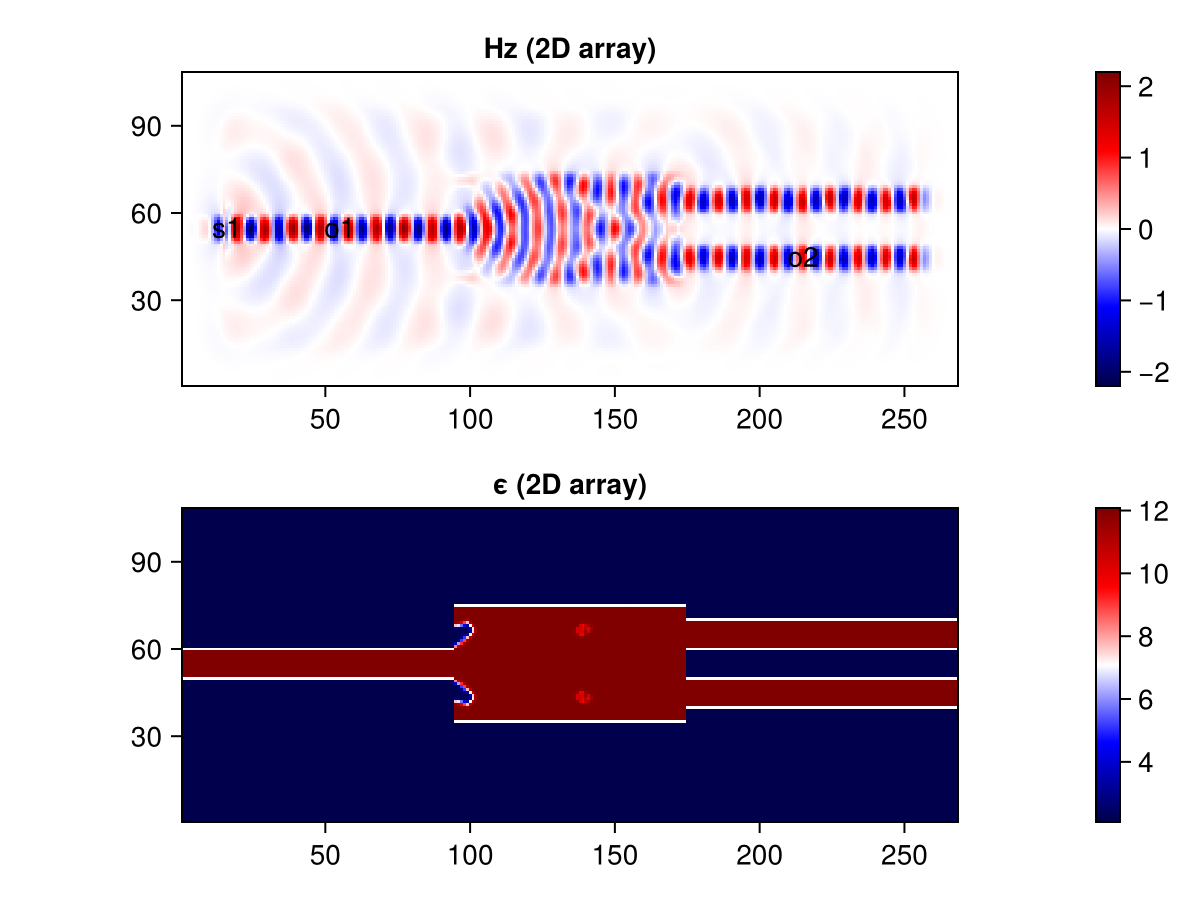

In [4]:
pprint(sol["tparams"])
lumi.show_solution(name=name)

Can get optimized gdsfactory component, also saved as `optimized_component.gds` in run folder. Can also find `design_region_1.gds` and `design_region_1.png` for just the optimized design regions.

In [ ]:
sol=load_solution()
c_opt=sol["optimized_component"]
c.plot()

### 1x4 splitter MMI
Need same phase on outputs. Because of symmetry, only need 0.0 phase difference between first 2 outputs.

2024-09-15 18:25:55.882 | WARNING  | kfactory.conf:_validate_layout_cache:254 - 'cell_layout_cache' has been set to True. This might cause when as any cell names generated automatically are loaded from the layout instead of created. This could happen e.g. after reading a gds file into the layout.

          using simulation folder C:\Users\pxshe\OneDrive\Desktop\Luminescent.jl\lumi\1x4_splitter
          started julia process
          compiling julia code...
          
setting up simulation...
using CPU backend.
starting optimization... first iter will be slow due to adjoint compilation.

(1) losses phasediff: 0.91069156 tparams: 0.6769296
weighted total loss 1.5876212
146.554199 seconds (49.43 M allocations: 39.256 GiB, 32.34% gc time, 24.61% compilation time)

(2) losses phasediff: 0.910584 tparams: 0.67691064
weighted total loss 1.5874946
144.969066 seconds (24.69 M allocations: 37.696 GiB, 44.29% gc time, 0.08% compilation time)

(3) losses phasediff: 0.87439936 tparams: 0.6671413

C:\Users\pxshe\AppData\Roaming\Python\Python311\site-packages\luminescent\gplugins\luminescent\inverse_design.py:146: UserWarning: Setting `Unnamed_660_0_0.xmin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_660_0_0.dxmin` instead.
  g.xmin = x0
C:\Users\pxshe\AppData\Roaming\Python\Python311\site-packages\luminescent\gplugins\luminescent\inverse_design.py:147: UserWarning: Setting `Unnamed_660_4000_0.ymin` in um is deprecated and will change to DataBaseUnits in gdsfactory9. Please use `Unnamed_660_4000_0.dymin` instead.
  g.ymin = y0


Converting an image file to a GDS file..
width:80
height:80
{'path': 'C:\\Users\\pxshe\\OneDrive\\Desktop\\Luminescent.jl\\lumi\\1x4_splitter',
 'sparams': {'1.55': {'o1@0,o1@0': (-0.0038846394+0.011446941j),
                      'o2@0,o1@0': (-0.45090324-0.25364265j),
                      'o3@0,o1@0': (-0.3740685-0.14722899j)}},
 'tparams': {'1.55': {'o1@0,o1@0': 0.00014612288,
                      'o2@0,o1@0': 0.2676483,
                      'o3@0,o1@0': 0.16160361}}}


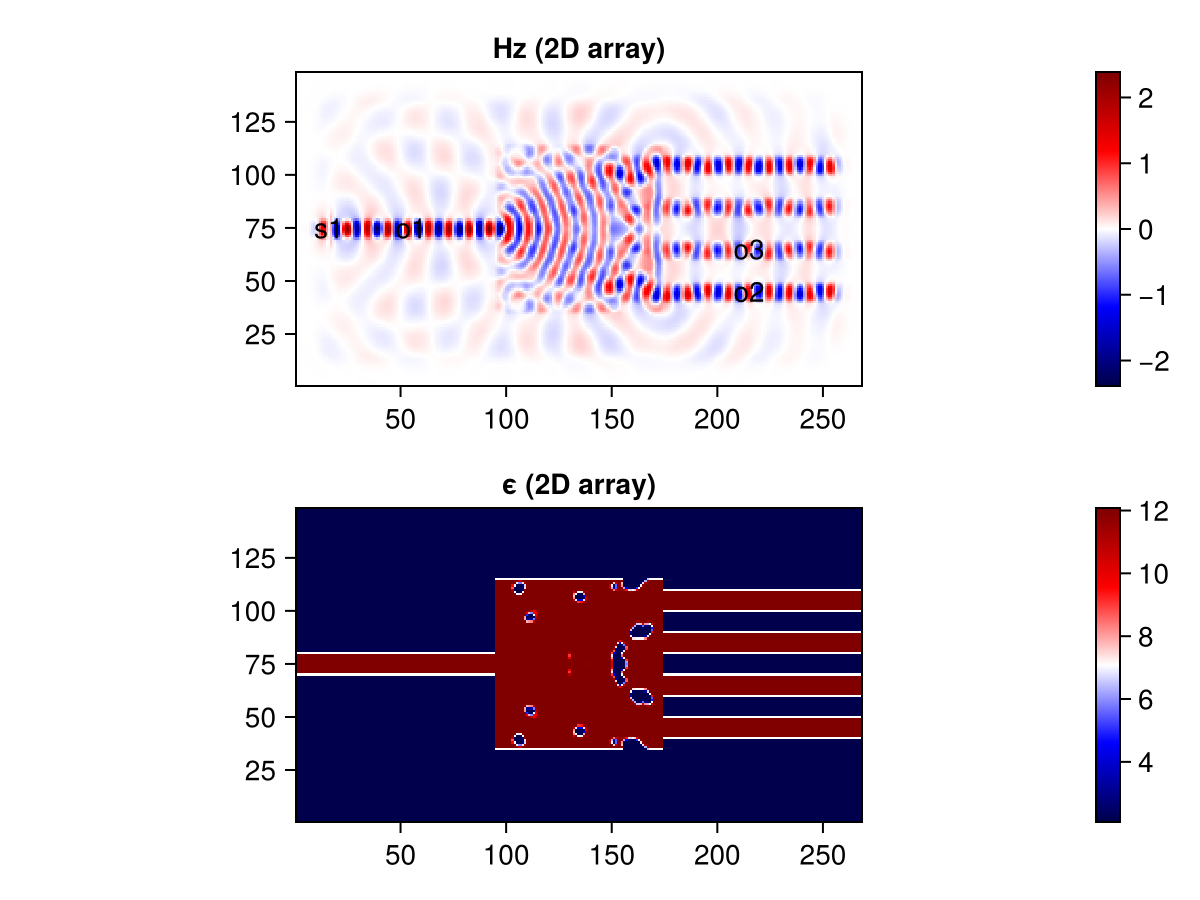

In [1]:
from pprint import pprint
import luminescent as lumi

name="1x4_splitter"
c = lumi.gcells.mimo(west=1, east=4, l=6.0, w=6.0, wwg=.5, name=name)
targets = {
    "tparams":{1.55: {"2,1": 0.25, "3,1":0.25}},
    "phasediff":{1.55: {"2,3": 0.0}},
    }

prob = lumi.gcell_problem(
    c, targets, 
    symmetries=[1], lmin=0.15, dx=0.05, 
    N=True, iters=30)
sol = lumi.solve(prob)

In [ ]:
finetune(iters=10,name=name)
lumi.show_solution()

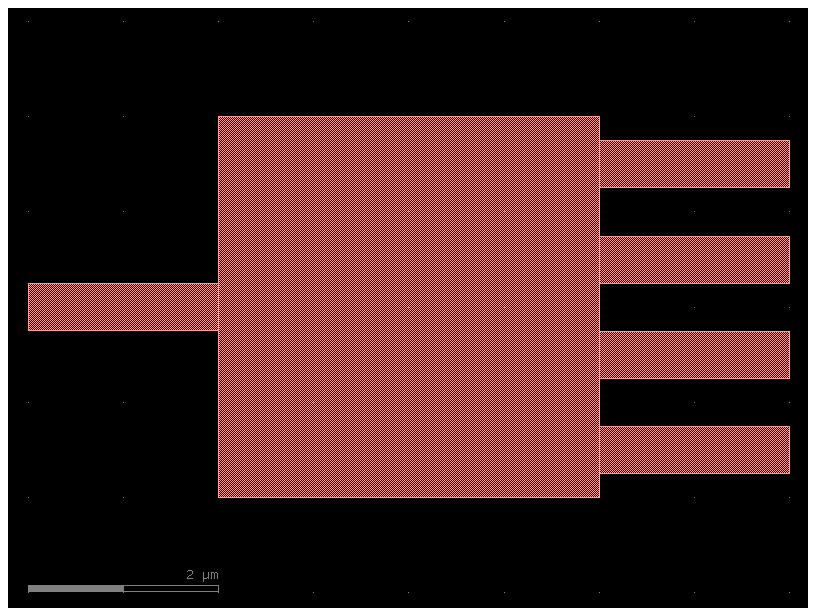

In [2]:
c_opt=sol["optimized_component"]
c.plot()

### wavelength domain demultiplexer

In [ ]:
from pprint import pprint
import luminescent as lumi

c = lumi.gcells.mimo(west=1, east=3, l=6.0, w=6.0, wwg=.5, name="demux")
targets = {"tparams":{
    1.55: {"2,1": 1.0},
    1.31: {"3,1": 1.0},
    1.10: {"4,1": 1.0},
}}

prob = lumi.gcell_problem(
    c, targets,
    lmin=0.1, dx=0.05, 
    N=True, iters=60, save_memory=True)
sol = lumi.solve(prob)

lumi.show_solution()

### mode converter
"o2@1,o1@0" means converting optical port 1 mode 0 to optical port 2 mode 1.

In [ ]:
from pprint import pprint
import luminescent as lumi

c = lumi.gcells.mimo(west=1, east=1, l=3.0, w=3.0, wwg=.5, name="mode_converter")
targets = {"tparams":{1.55: {"o2@1,o1@0": 1.0}}}

prob = lumi.gcell_problem(
    c, targets,
    lmin=0.1, dx=0.05, 
    N=True, iters=40, save_memory=True)
sol = lumi.solve(prob)

lumi.show_solution()

### symmetric crossing 

In [ ]:
from pprint import pprint
import luminescent as lumi

c = lumi.gcells.mimo(west=1, east=1, south=1, north=1, l=4.0, w=4.0, wwg=.5, name="crossing")
targets = {"tparams":{1.55: {"2,1": 1.0}}}

prob = lumi.gcell_problem(
    c, targets,
    lmin=0.1, dx=0.05, symmetries=[0,"diag"],
    N=True, iters=40, save_memory=True)
sol = lumi.solve(prob)

lumi.show_solution()

# 

# S-parameters simulation

One can choose to do only a subset of sparams in case of symmetric devices by specifying `keys`. if `keys` omitted, all sparams will be calculated


## SOI 220nm

### straight Si waveguide 

In [ ]:
import luminescent as lumi
from luminescent import MATERIALS
from gdsfactory.generic_tech import LAYER,LAYER_STACK
import gdsfactory as gf
import pprint as pp

c = gf.components.straight(1.0,width=0.5,layer=LAYER.WG)
c.plot()

#### TE0

In [ ]:
# TE0 on GPU
sol = lumi.write_sparams(c, wavelengths=1.55, keys=["2,1"], # same as keys=["o2@0,o1@0"]
                      core_layer=LAYER.WG,   bbox_layer=LAYER.WAFER, # defaults
                         layer_stack=LAYER_STACK, materials=MATERIALS, # defaults
     dx=0.05, N=3, dtype="float32", gpu="CUDA",) # or gpu=None
lumi.show_solution()

#### TE1

In [ ]:
sol = lumi.write_sparams(c, wavelengths=[1.55], keys=["o2@1,o1@1"],
     dx=0.05, N=3, dtype="float32", gpu="CUDA",) # or gpu=None
lumi.show_solution()

#### TE0 multiple wavelengths

In [ ]:
sol = lumi.write_sparams(c, wavelengths=[.85, 1.55], keys=["2,1"],
     dx=0.05, N=3, dtype="float32", gpu="CUDA",) # or gpu=None
# sol = lumi.load_solution()
lumi.show_solution()

### Si rib waveguide
only need to modify bbox_layer to include 90nm bottom silicon slab

In [ ]:
sol = lumi.write_sparams(c, wavelengths=[1.55], keys=["2,1"], # same as keys=["o2@0,o1@0"]
                      core_layer=LAYER.WG,   bbox_layer=[LAYER.WAFER,LAYER.SLAB90],
     dx=0.05, N=3, dtype="float32", gpu="CUDA",) # or gpu=None
# sol = lumi.load_solution()
lumi.show_solution()

### SiN strip waveguide

In [ ]:
import luminescent as lumi
from luminescent import MATERIALS
from gdsfactory.generic_tech import LAYER,LAYER_STACK
import gdsfactory as gf

c = gf.components.straight(length=1.5,width=1.0,layer=LAYER.WGN)
sol = lumi.write_sparams(c, wavelengths=[1.55], keys=["2,1"], # same as keys=["o2@0,o1@0"]
                      core_layer=LAYER.WGN,   bbox_layer=LAYER.WAFER, # defaults
     dx=0.05, N=3, dtype="float32", gpu="CUDA",) # or gpu=None
# sol = lumi.load_solution()
lumi.show_solution()

# Advanced features
Following can be requested from info@luminescentai.com (mention your position and organization ):
- 3generativese desiGPU
- non-CUDA GPU